<a href="https://colab.research.google.com/github/j28302830/Senior_Project/blob/main/reconized_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Samples and Models file

In [211]:
!wget http://dataset.tlm.unavarra.es/ransomware/samplesAndModels.tar.xz
!tar -Jxvf /content/samplesAndModels.tar.xz &> /dev/null

--2022-05-16 15:16:52--  http://dataset.tlm.unavarra.es/ransomware/samplesAndModels.tar.xz
Resolving dataset.tlm.unavarra.es (dataset.tlm.unavarra.es)... 130.206.160.87
Connecting to dataset.tlm.unavarra.es (dataset.tlm.unavarra.es)|130.206.160.87|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41519408 (40M) [application/x-xz]
Saving to: ‘samplesAndModels.tar.xz.4’

samplesAndModels.ta 100%[===================>]  39.60M  9.99MB/s    in 5.1s    

2022-05-16 15:16:59 (7.81 MB/s) - ‘samplesAndModels.tar.xz.4’ saved [41519408/41519408]



# Import Package

In [212]:
import tensorflow as tf
import keras
import glob
import numpy as np
from pickle import load
import joblib 

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import plotly.express as px
pd.set_option('max_rows', 99999)

# Predefined Function

In [213]:
def load_sample(local_path):
  filenames = glob.glob(local_path + "/*.txt")
  for i,filename in enumerate(filenames):
    if i == 0:
      x = np.loadtxt(filename, delimiter=',', dtype = 'float32')
    else: 
      ds = np.loadtxt(filename, delimiter=',', dtype = 'float32')
      x = np.concatenate((x, ds), axis=0)

  return x

In [214]:
def metrics(model , x, y):
  predict = model.predict(x)
  predict[predict >= 0.99] = 1
  predict[predict < 0.99] = 0

  true_values = y
  predictions = predict

  TP = ((predictions == 1) & (true_values == 1)).sum()
  FP = ((predictions == 1) & (true_values == 0)).sum()
  TN = ((predictions == 0) & (true_values == 0)).sum()
  FN = ((predictions == 0) & (true_values == 1)).sum()

  accuracy = (TP+TN) / (TP+FP+TN+FN)
  precision = TP / (TP+FP)
  recall = TP / (TP+FN)
  f_measure = 2*(precision*recall/(precision+recall))
  temp = ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))** 0.5
  phi_coefficient = (TP*TN-FP*FN) / temp
  
  mat = confusion_matrix(true_values,predictions)

  print("accuracy score:", accuracy_score(true_values, predictions))
    
  sns.heatmap(mat,square= True, annot=True, cbar= False)
  plt.xlabel("predicted value")
  plt.ylabel("true value")
  plt.show()
  
  evaluate = model.evaluate(x=x, y=y)

  return [evaluate[1], accuracy, precision, recall, f_measure, phi_coefficient]

In [215]:
def scale(feature):
  scaler = joblib.load('/content/scaler.scaler')
  feature_scaled = scaler.transform(feature)
  feature_scaled_10X3 = np.reshape(feature_scaled, (feature_scaled.shape[0], 10, 3))
  return feature_scaled, feature_scaled_10X3

# Load NN, CNN, and LSTM model

In [216]:
model_NN = tf.keras.models.load_model('/content/NN_CNN_LSTM_Comparison/NN')
model_CNN = tf.keras.models.load_model('/content/NN_CNN_LSTM_Comparison/CNN')
model_LSTM = tf.keras.models.load_model('/content/NN_CNN_LSTM_Comparison/LSTM')

JSON

In [217]:
json_file = open('/content/NN.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)

# Load sample

In [218]:
index = list(range(0, 30)) #show range of feature index 
test = load_sample(local_path = r'/content/samples/ransomwareSamples_test')
train = load_sample(local_path = r'/content/samples/ransomwareSamples_train')
all_ransomware = np.concatenate( (train, test), axis = 0 )
day_zero = np.loadtxt('/content/samples/userSamples/day0.txt', delimiter=',', dtype = 'float32')

# Preprocessing Sample and Run Model 

### day0 and all ransomware sample

In [219]:
label = np.delete(all_ransomware, index + [31], axis=1)
feature = np.delete(all_ransomware, [30,31], axis=1)


label2 = np.delete(day_zero, index, axis=1)
feature2 = np.delete(day_zero, [30], axis=1)

label = np.concatenate( (label, label2), axis = 0 )
feature = np.concatenate( (feature, feature2), axis = 0 )

feature_scaled, feature_scaled_10X3 = scale(feature)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning:

overflow encountered in long_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in power



accuracy score: 0.9661494324461659


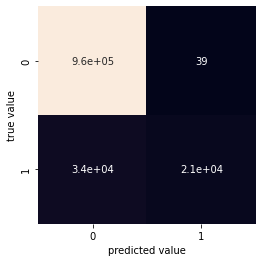

31611/31611 [==============================] - 67s 2ms/step - loss: 1.8139 - accuracy: 0.9668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning:

overflow encountered in long_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in power



accuracy score: 0.9655958178370673


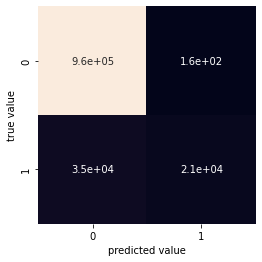

31611/31611 [==============================] - 58s 2ms/step - loss: 0.4569 - accuracy: 0.9664


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning:

overflow encountered in long_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in power



accuracy score: 0.9655730800941936


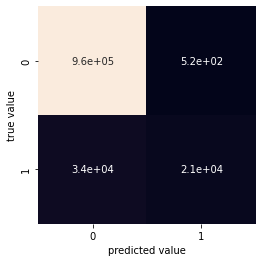

31611/31611 [==============================] - 122s 4ms/step - loss: 0.4148 - accuracy: 0.9658
NN:
accuracy(): 0.966149
CNN:
accuracy(): 0.965596
LSTM:
accuracy(): 0.965573


In [220]:
NN = metrics(model_NN, x=feature_scaled, y=label)
CNN = metrics(model_CNN, x=feature_scaled_10X3, y=label)
LSTM = metrics(model_LSTM, x=feature_scaled_10X3, y=label)
print("NN:\naccuracy(): %f" %NN[1] )
print("CNN:\naccuracy(): %f" %CNN[1] )
print("LSTM:\naccuracy(): %f" %LSTM[1] )

### test sample without low activity data

In [221]:
label = np.delete(test, index + [31], axis=1)
feature = np.delete(test, [30,31], axis=1)

count = np.count_nonzero(feature == 0, axis=1)
low_activity = np.where( count >= (feature.shape[1]/3) )

label = np.delete(label, low_activity, axis=0)
feature = np.delete(feature, low_activity, axis=0)

feature_scaled, feature_scaled_10X3 = scale(feature)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations



accuracy score: 0.952518756698821


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



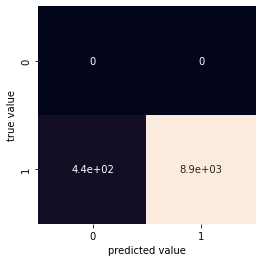

292/292 [==============================] - 1s 2ms/step - loss: 0.2123 - accuracy: 0.9735
accuracy score: 0.9371918542336549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



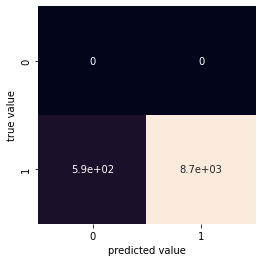

292/292 [==============================] - 1s 2ms/step - loss: 0.0818 - accuracy: 0.9772
accuracy score: 0.9468381564844587


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



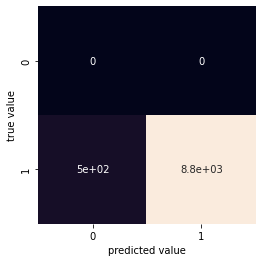

292/292 [==============================] - 1s 4ms/step - loss: 0.1293 - accuracy: 0.9803
NN:
accuracy(): 0.952519
CNN:
accuracy(): 0.937192
LSTM:
accuracy(): 0.946838


In [222]:
NN = metrics(model_NN, x=feature_scaled, y=label)
CNN = metrics(model_CNN, x=feature_scaled_10X3, y=label)
LSTM = metrics(model_LSTM, x=feature_scaled_10X3, y=label)
print("NN:\naccuracy(): %f" %NN[1] )
print("CNN:\naccuracy(): %f" %CNN[1] )
print("LSTM:\naccuracy(): %f" %LSTM[1] )

### train sample

In [223]:
label = np.delete(train, index + [31], axis=1)
feature = np.delete(train, [30,31], axis=1)

feature_scaled, feature_scaled_10X3 = scale(feature)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations



accuracy score: 0.9860303687635574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



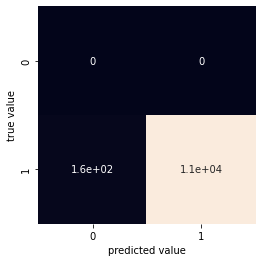

361/361 [==============================] - 1s 2ms/step - loss: 0.0337 - accuracy: 0.9956
accuracy score: 0.9840347071583514


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



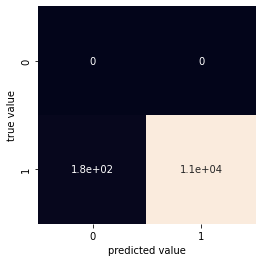

361/361 [==============================] - 1s 2ms/step - loss: 0.0240 - accuracy: 0.9946
accuracy score: 0.9742299349240781


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



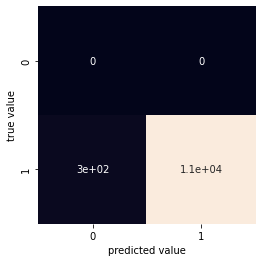

361/361 [==============================] - 1s 4ms/step - loss: 0.0799 - accuracy: 0.9894
NN:
accuracy(): 0.986030
CNN:
accuracy(): 0.984035
LSTM:
accuracy(): 0.974230


In [224]:
NN = metrics(model_NN, x=feature_scaled, y=label)
CNN = metrics(model_CNN, x=feature_scaled_10X3, y=label)
LSTM = metrics(model_LSTM, x=feature_scaled_10X3, y=label)
print("NN:\naccuracy(): %f" %NN[1] )
print("CNN:\naccuracy(): %f" %CNN[1] )
print("LSTM:\naccuracy(): %f" %LSTM[1] )

### all ransomware sample

In [225]:
index = list(range(0, 30))

label = np.delete(train, index + [31], axis=1)
feature = np.delete(train, [30,31], axis=1)

label2 = np.delete(test, index + [31], axis=1)
feature2 = np.delete(test, [30,31], axis=1)

label = np.concatenate( (label, label2), axis = 0 )
feature = np.concatenate( (feature, feature2), axis = 0 )

count = np.count_nonzero(feature == 0, axis=1)
low_activity = np.where( count >= (feature.shape[1]/3) )

label = np.delete(label, low_activity, axis=0)
feature = np.delete(feature, low_activity, axis=0)

feature_scaled, feature_scaled_10X3 = scale(feature)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations



accuracy score: 0.971038120354831


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



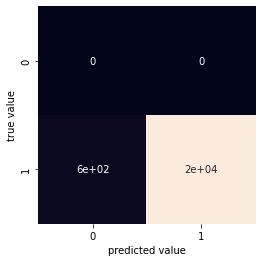

652/652 [==============================] - 1s 2ms/step - loss: 0.1136 - accuracy: 0.9857
accuracy score: 0.9630783984655957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



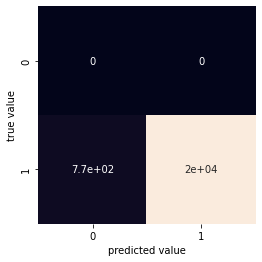

652/652 [==============================] - 1s 2ms/step - loss: 0.0499 - accuracy: 0.9868
accuracy score: 0.96197554543275


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



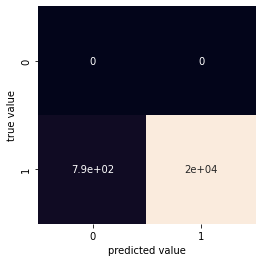

652/652 [==============================] - 2s 4ms/step - loss: 0.1020 - accuracy: 0.9853
NN:
accuracy(): 0.971038
CNN:
accuracy(): 0.963078
LSTM:
accuracy(): 0.961976


In [226]:
NN = metrics(model_NN, x=feature_scaled, y=label)
CNN = metrics(model_CNN, x=feature_scaled_10X3, y=label)
LSTM = metrics(model_LSTM, x=feature_scaled_10X3, y=label)
print("NN:\naccuracy(): %f" %NN[1] )
print("CNN:\naccuracy(): %f" %CNN[1] )
print("LSTM:\naccuracy(): %f" %LSTM[1] )

### test sample(each ransomware) without low activity data 

In [227]:
category = []
sample = []
local_path = r'/content/samples/ransomwareSamples_test'
filenames = glob.glob(local_path + "/*.txt")
for i,filename in enumerate(filenames):
  name = filename.replace(local_path + "/",'').replace('.txt', '')
  sample.append(name[0:name.find('_')])
  

In [228]:
category = sorted(set(sample))
print(category)

['Aleta', 'CTBLocker', 'CryLock', 'CrypMIC', 'CryptFile2', 'CryptoFortress', 'CryptoMix', 'CryptoShield', 'Crysis', 'Cryxox', 'DMALocker', 'Dharma', 'Diablo6', 'Eris', 'GandCrab', 'GlobeImposter', 'Jaff', 'Locky', 'MRCR', 'Maze', 'Mole', 'Odin', 'Phobos', 'RansomX', 'Razi', 'Ryuk', 'Sage', 'Scarab', 'Shade', 'Shaofao', 'Sodinokibi', 'Spora', 'Stop', 'TeslaCrypt', 'Virlock', 'Zeus', 'bart', 'bitPaymer', 'cerber', 'maktub', 'netwalker', 'revenge', 'wannaCry']




Aleta


accuracy score: 0.6196319018404908


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



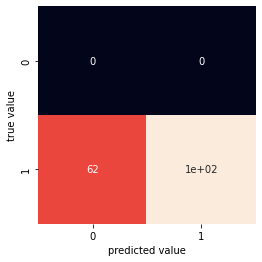

6/6 [==============================] - 0s 3ms/step - loss: 1.7671 - accuracy: 0.6380
accuracy score: 0.5828220858895705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



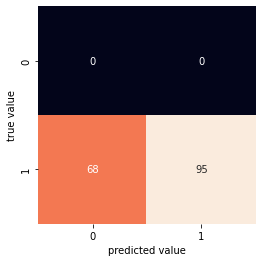

6/6 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6564
accuracy score: 0.9693251533742331


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



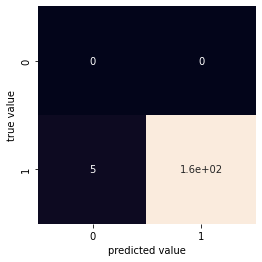

6/6 [==============================] - 0s 4ms/step - loss: 0.0279 - accuracy: 0.9939


CTBLocker


accuracy score: 0.6914893617021277


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



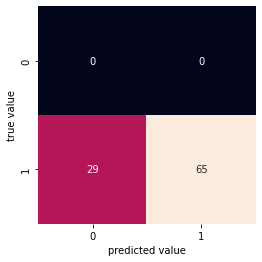

3/3 [==============================] - 0s 5ms/step - loss: 2.6289 - accuracy: 0.7447
accuracy score: 0.8191489361702128


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



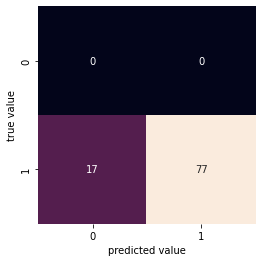

3/3 [==============================] - 0s 5ms/step - loss: 0.2825 - accuracy: 0.9149
accuracy score: 0.7553191489361702


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



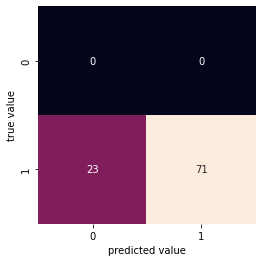

3/3 [==============================] - 0s 7ms/step - loss: 0.5220 - accuracy: 0.8617


CryLock


accuracy score: 0.875


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



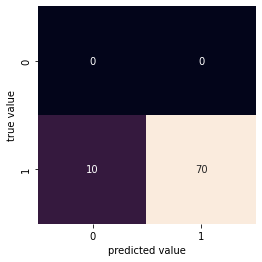

3/3 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 0.9500
accuracy score: 0.9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



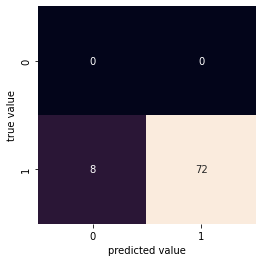

3/3 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.9750
accuracy score: 0.9125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



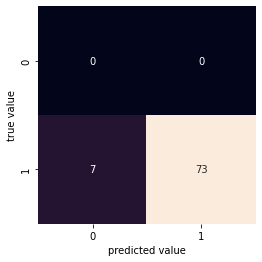

3/3 [==============================] - 0s 6ms/step - loss: 0.0256 - accuracy: 0.9875


CrypMIC


accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



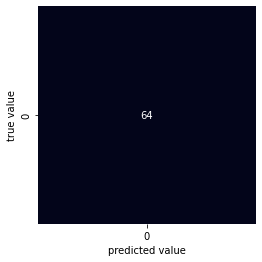

2/2 [==============================] - 0s 9ms/step - loss: 1.1372e-04 - accuracy: 1.0000
accuracy score: 0.921875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



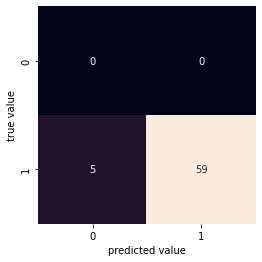

2/2 [==============================] - 0s 8ms/step - loss: 0.0036 - accuracy: 1.0000
accuracy score: 0.953125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



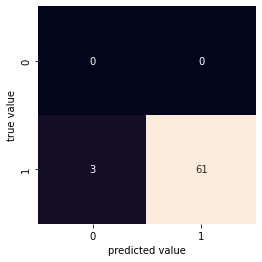

2/2 [==============================] - 1s 8ms/step - loss: 0.0556 - accuracy: 0.9844


CryptFile2


accuracy score: 0.9813084112149533


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



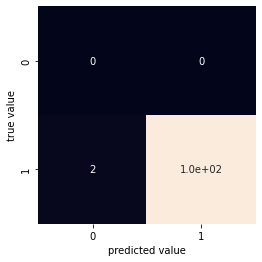

4/4 [==============================] - 0s 4ms/step - loss: 6.9594e-04 - accuracy: 1.0000
accuracy score: 0.9158878504672897


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



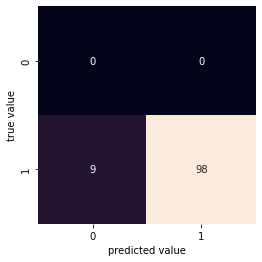

4/4 [==============================] - 0s 4ms/step - loss: 0.0048 - accuracy: 1.0000
accuracy score: 0.9719626168224299


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



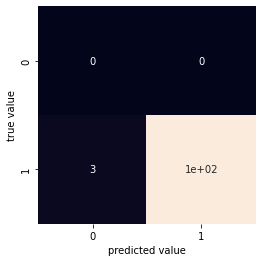

4/4 [==============================] - 0s 6ms/step - loss: 0.0085 - accuracy: 1.0000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations





CryptoFortress


accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



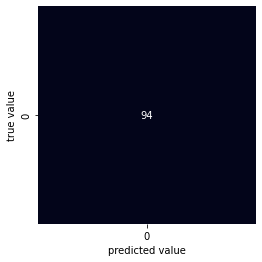

3/3 [==============================] - 0s 5ms/step - loss: 4.9624e-05 - accuracy: 1.0000
accuracy score: 0.9574468085106383


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



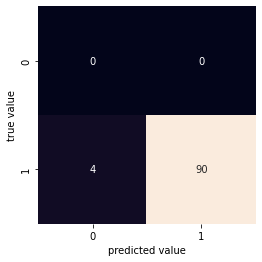

3/3 [==============================] - 0s 7ms/step - loss: 0.0049 - accuracy: 1.0000
accuracy score: 0.9893617021276596


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



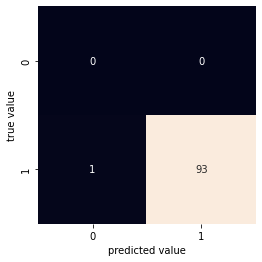

3/3 [==============================] - 0s 6ms/step - loss: 5.3964e-04 - accuracy: 1.0000


CryptoMix


accuracy score: 0.9789915966386554


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



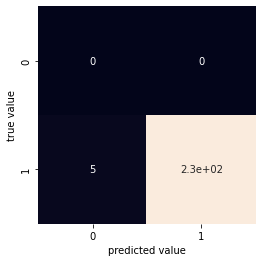

8/8 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9916
accuracy score: 0.9327731092436975


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



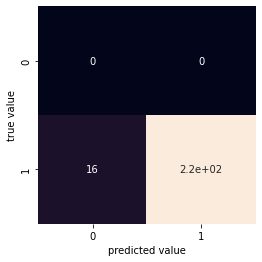

8/8 [==============================] - 0s 3ms/step - loss: 0.0115 - accuracy: 0.9958
accuracy score: 0.9453781512605042


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



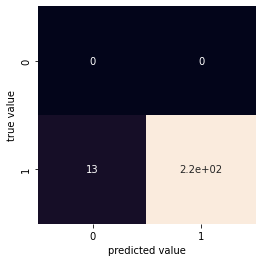

8/8 [==============================] - 0s 4ms/step - loss: 0.0295 - accuracy: 0.9958


CryptoShield


accuracy score: 0.963302752293578


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



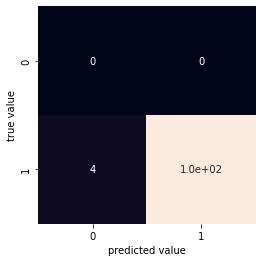

4/4 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 1.0000
accuracy score: 0.944954128440367


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



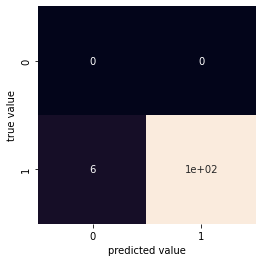

4/4 [==============================] - 0s 3ms/step - loss: 0.0054 - accuracy: 1.0000
accuracy score: 0.944954128440367


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



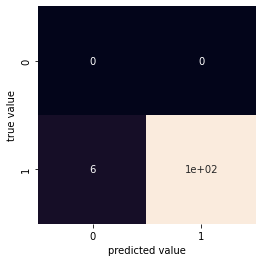

4/4 [==============================] - 0s 6ms/step - loss: 0.0505 - accuracy: 0.9908


Crysis


accuracy score: 0.9464751958224543


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



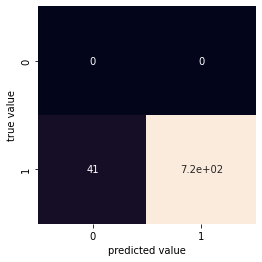

24/24 [==============================] - 0s 3ms/step - loss: 0.1013 - accuracy: 0.9765
accuracy score: 0.8903394255874674


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



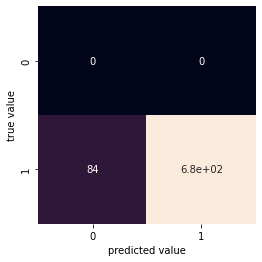

24/24 [==============================] - 0s 2ms/step - loss: 0.0676 - accuracy: 0.9791
accuracy score: 0.9347258485639687


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



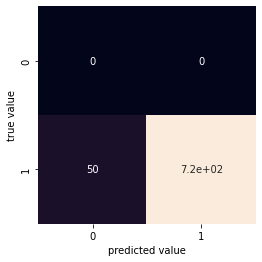

24/24 [==============================] - 0s 4ms/step - loss: 0.1563 - accuracy: 0.9752


Cryxox


accuracy score: 0.9772727272727273


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



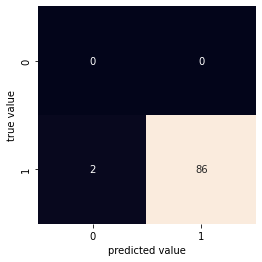

3/3 [==============================] - 0s 5ms/step - loss: 0.0959 - accuracy: 0.9886
accuracy score: 0.9886363636363636


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



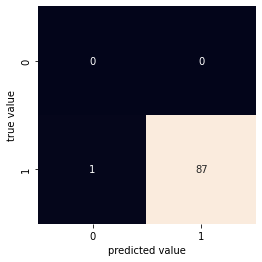

3/3 [==============================] - 0s 6ms/step - loss: 0.0026 - accuracy: 1.0000
accuracy score: 0.9886363636363636


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



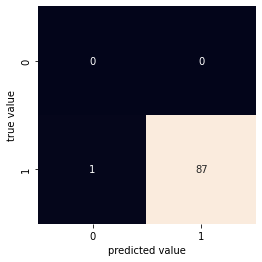

3/3 [==============================] - 0s 8ms/step - loss: 6.1012e-04 - accuracy: 1.0000


DMALocker


accuracy score: 0.9624060150375939


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



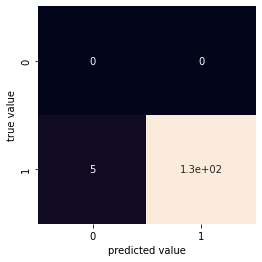

5/5 [==============================] - 0s 4ms/step - loss: 0.0063 - accuracy: 1.0000
accuracy score: 0.9097744360902256


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



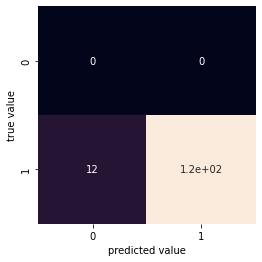

5/5 [==============================] - 0s 4ms/step - loss: 0.1117 - accuracy: 0.9699
accuracy score: 0.9172932330827067


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



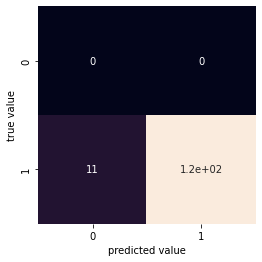

5/5 [==============================] - 0s 5ms/step - loss: 0.0816 - accuracy: 0.9774


Dharma


accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



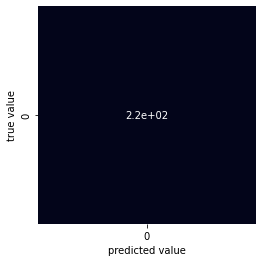

7/7 [==============================] - 0s 3ms/step - loss: 6.1060e-05 - accuracy: 1.0000
accuracy score: 0.9629629629629629


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



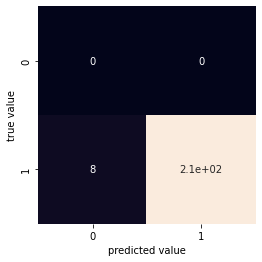

7/7 [==============================] - 0s 4ms/step - loss: 0.0180 - accuracy: 0.9954
accuracy score: 0.9953703703703703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



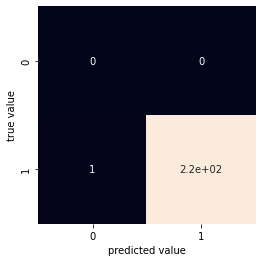

7/7 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 1.0000


Diablo6


accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



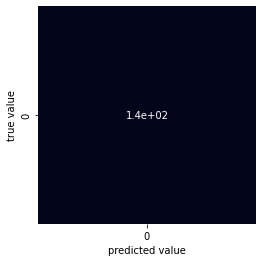

5/5 [==============================] - 0s 4ms/step - loss: 7.8208e-05 - accuracy: 1.0000
accuracy score: 0.9928571428571429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



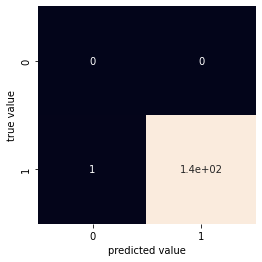

5/5 [==============================] - 0s 5ms/step - loss: 0.0011 - accuracy: 1.0000
accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



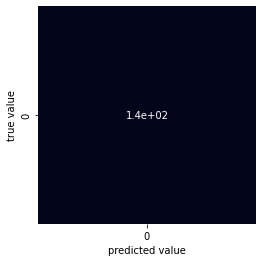

5/5 [==============================] - 0s 5ms/step - loss: 1.6668e-04 - accuracy: 1.0000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations





Eris


accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



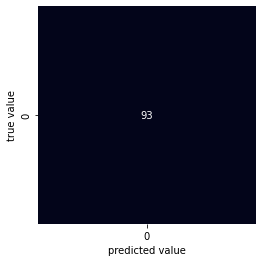

3/3 [==============================] - 0s 5ms/step - loss: 8.0077e-06 - accuracy: 1.0000
accuracy score: 0.989247311827957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



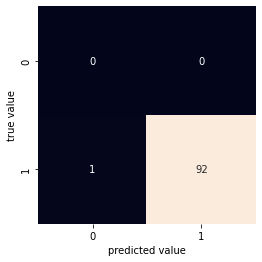

3/3 [==============================] - 0s 6ms/step - loss: 9.5877e-04 - accuracy: 1.0000
accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



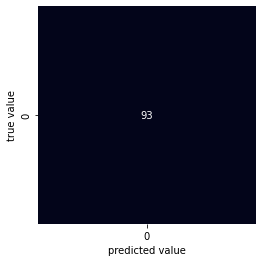

3/3 [==============================] - 0s 8ms/step - loss: 1.5036e-04 - accuracy: 1.0000


GandCrab


accuracy score: 0.9954128440366973


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



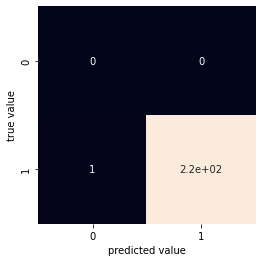

7/7 [==============================] - 0s 3ms/step - loss: 0.0460 - accuracy: 0.9954
accuracy score: 0.9862385321100917


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



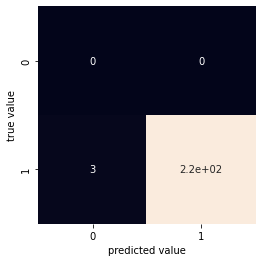

7/7 [==============================] - 0s 3ms/step - loss: 3.3591e-04 - accuracy: 1.0000
accuracy score: 0.9954128440366973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



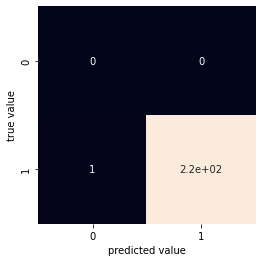

7/7 [==============================] - 0s 4ms/step - loss: 3.0740e-04 - accuracy: 1.0000


GlobeImposter


accuracy score: 0.9837837837837838


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



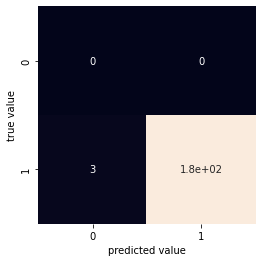

6/6 [==============================] - 0s 4ms/step - loss: 6.0735e-04 - accuracy: 1.0000
accuracy score: 0.9945945945945946


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



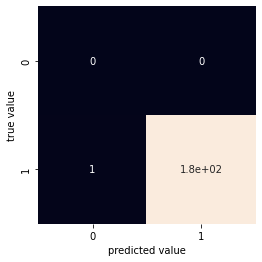

6/6 [==============================] - 0s 3ms/step - loss: 3.1288e-04 - accuracy: 1.0000
accuracy score: 0.9945945945945946


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



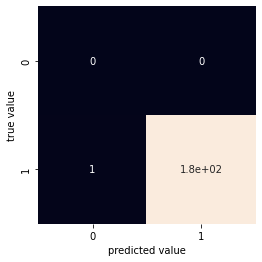

6/6 [==============================] - 0s 5ms/step - loss: 0.0338 - accuracy: 0.9946


Jaff


accuracy score: 0.996


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



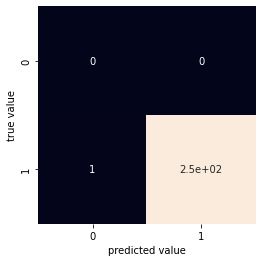

8/8 [==============================] - 0s 3ms/step - loss: 1.7224e-04 - accuracy: 1.0000
accuracy score: 0.956


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



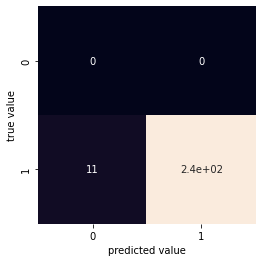

8/8 [==============================] - 0s 3ms/step - loss: 0.0589 - accuracy: 0.9840
accuracy score: 0.968


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



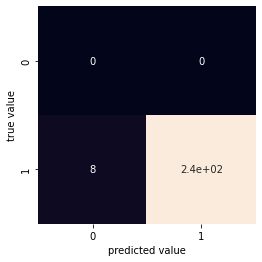

8/8 [==============================] - 0s 5ms/step - loss: 0.0036 - accuracy: 1.0000


Locky




/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



accuracy score: 0.9848369977255497


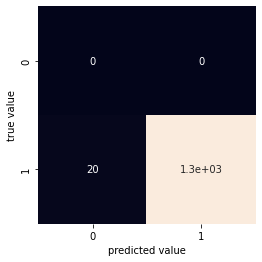

42/42 [==============================] - 0s 3ms/step - loss: 0.0491 - accuracy: 0.9947
accuracy score: 0.9628506444275967


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



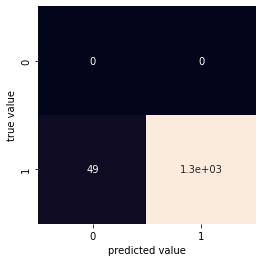

42/42 [==============================] - 0s 2ms/step - loss: 0.0223 - accuracy: 0.9932
accuracy score: 0.9529946929492039


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



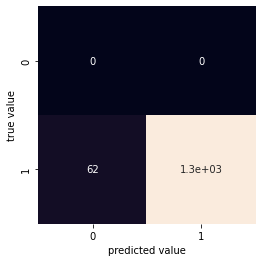

42/42 [==============================] - 0s 4ms/step - loss: 0.1430 - accuracy: 0.9788


MRCR


accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



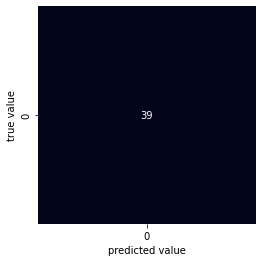

2/2 [==============================] - 0s 5ms/step - loss: 1.1028e-05 - accuracy: 1.0000
accuracy score: 0.8717948717948718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



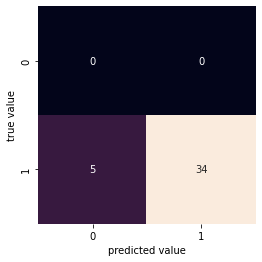

2/2 [==============================] - 0s 5ms/step - loss: 0.0046 - accuracy: 1.0000
accuracy score: 0.8717948717948718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



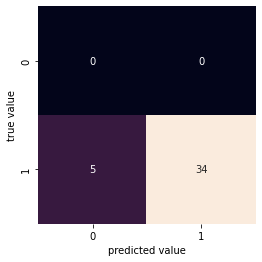

2/2 [==============================] - 0s 18ms/step - loss: 0.1144 - accuracy: 0.9744


Maze


accuracy score: 0.9724770642201835


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



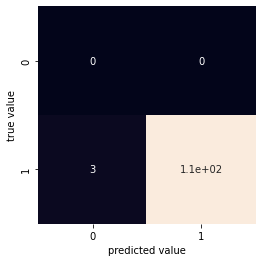

4/4 [==============================] - 0s 4ms/step - loss: 0.0130 - accuracy: 0.9908
accuracy score: 0.9724770642201835


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



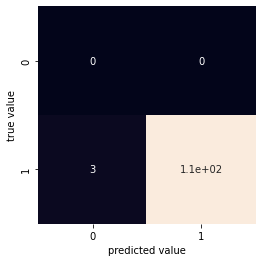

4/4 [==============================] - 0s 4ms/step - loss: 0.0016 - accuracy: 1.0000
accuracy score: 0.981651376146789


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



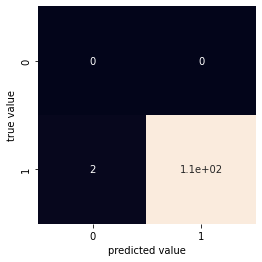

4/4 [==============================] - 0s 8ms/step - loss: 0.0159 - accuracy: 0.9908


Mole


accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



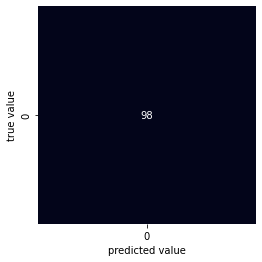

4/4 [==============================] - 0s 6ms/step - loss: 3.1313e-05 - accuracy: 1.0000
accuracy score: 0.9591836734693877


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



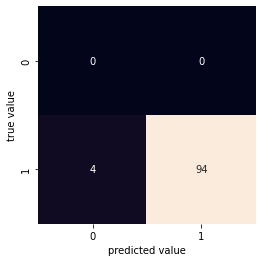

4/4 [==============================] - 0s 3ms/step - loss: 0.0249 - accuracy: 0.9898
accuracy score: 0.9795918367346939


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



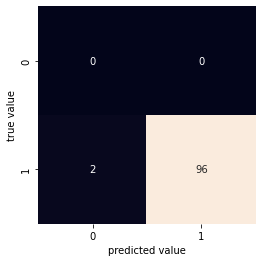

4/4 [==============================] - 0s 8ms/step - loss: 8.3635e-04 - accuracy: 1.0000


Odin


accuracy score: 0.9793103448275862


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



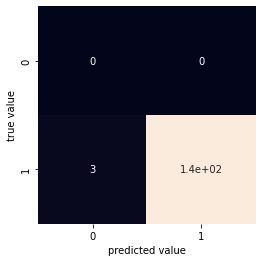

5/5 [==============================] - 0s 5ms/step - loss: 0.1136 - accuracy: 0.9931
accuracy score: 0.9517241379310345


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



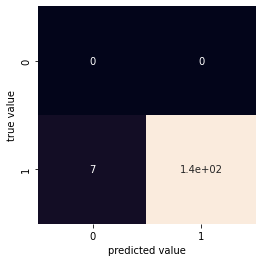

5/5 [==============================] - 0s 4ms/step - loss: 0.0149 - accuracy: 0.9931
accuracy score: 0.9448275862068966


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



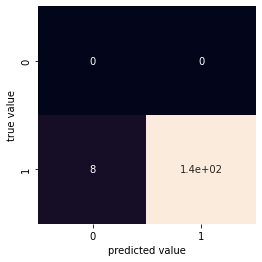

5/5 [==============================] - 0s 5ms/step - loss: 0.1913 - accuracy: 0.9655


Phobos


accuracy score: 0.8809523809523809


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



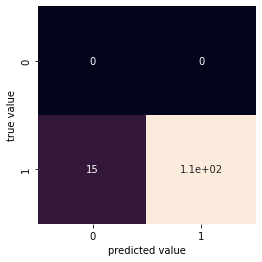

4/4 [==============================] - 0s 5ms/step - loss: 0.1424 - accuracy: 0.9524
accuracy score: 0.7777777777777778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



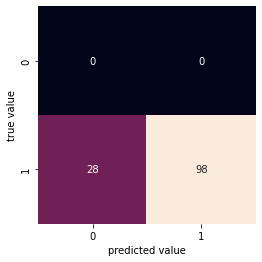

4/4 [==============================] - 0s 4ms/step - loss: 0.1655 - accuracy: 0.9683
accuracy score: 0.7936507936507936


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



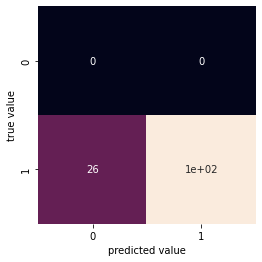

4/4 [==============================] - 0s 6ms/step - loss: 0.4498 - accuracy: 0.9048


RansomX


accuracy score: 0.972972972972973


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



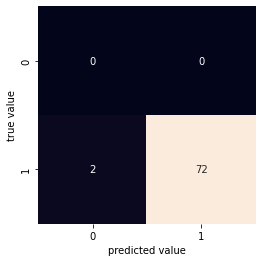

3/3 [==============================] - 0s 7ms/step - loss: 0.0756 - accuracy: 0.9730
accuracy score: 0.972972972972973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



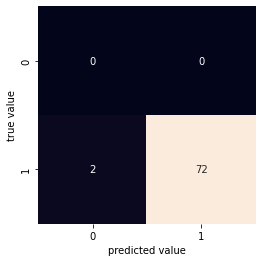

3/3 [==============================] - 0s 6ms/step - loss: 0.0196 - accuracy: 0.9865
accuracy score: 0.972972972972973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



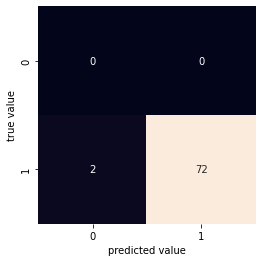

3/3 [==============================] - 0s 7ms/step - loss: 0.0628 - accuracy: 0.9865


Razi


accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



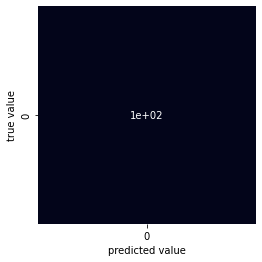

4/4 [==============================] - 0s 6ms/step - loss: 1.5040e-05 - accuracy: 1.0000
accuracy score: 0.9805825242718447


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



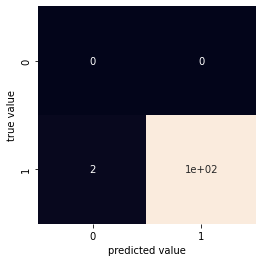

4/4 [==============================] - 0s 5ms/step - loss: 0.0011 - accuracy: 1.0000
accuracy score: 0.9902912621359223


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



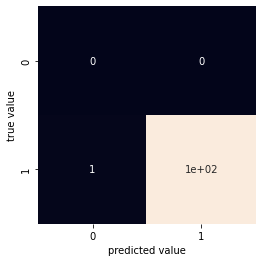

4/4 [==============================] - 0s 6ms/step - loss: 0.0325 - accuracy: 0.9903


Ryuk


accuracy score: 0.9428571428571428


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



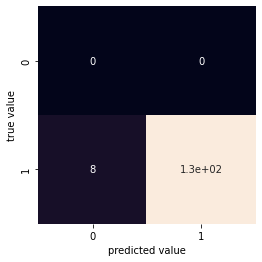

5/5 [==============================] - 0s 5ms/step - loss: 0.1479 - accuracy: 0.9857
accuracy score: 0.9428571428571428


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



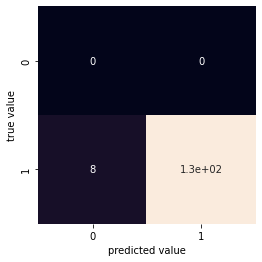

5/5 [==============================] - 0s 4ms/step - loss: 0.0405 - accuracy: 0.9857
accuracy score: 0.9714285714285714


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



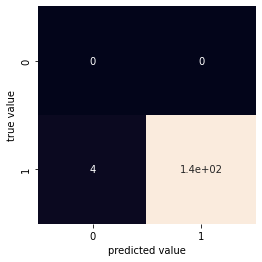

5/5 [==============================] - 0s 5ms/step - loss: 0.0710 - accuracy: 0.9929


Sage


accuracy score: 0.9783653846153846


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



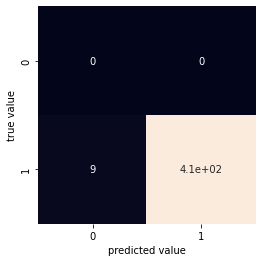

13/13 [==============================] - 0s 3ms/step - loss: 0.0392 - accuracy: 0.9928
accuracy score: 0.9831730769230769


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



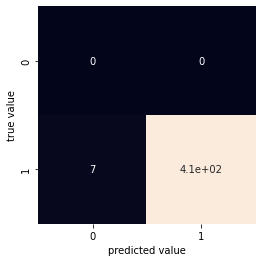

13/13 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 0.9976
accuracy score: 0.9759615384615384


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



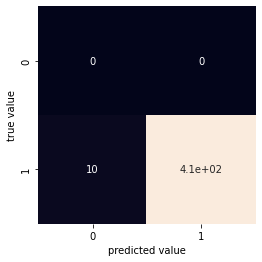

13/13 [==============================] - 0s 6ms/step - loss: 0.0097 - accuracy: 0.9928


Scarab


accuracy score: 0.9146341463414634


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



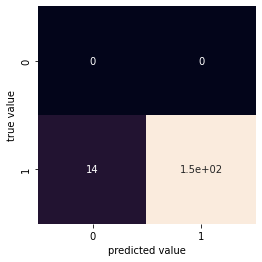

6/6 [==============================] - 0s 4ms/step - loss: 0.0472 - accuracy: 0.9817
accuracy score: 0.9634146341463414


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



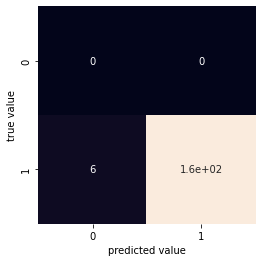

6/6 [==============================] - 0s 5ms/step - loss: 0.0316 - accuracy: 0.9878
accuracy score: 0.7865853658536586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



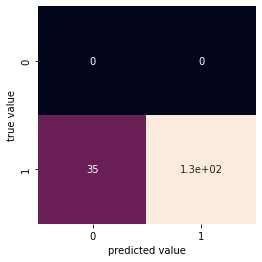

6/6 [==============================] - 0s 5ms/step - loss: 0.3411 - accuracy: 0.9390


Shade


accuracy score: 0.9837837837837838


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



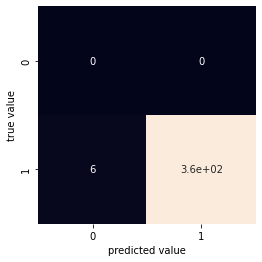

12/12 [==============================] - 0s 3ms/step - loss: 4.9892e-04 - accuracy: 1.0000
accuracy score: 0.9891891891891892


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



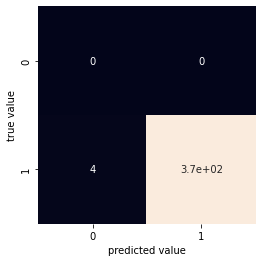

12/12 [==============================] - 0s 3ms/step - loss: 3.0225e-04 - accuracy: 1.0000
accuracy score: 0.9891891891891892


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



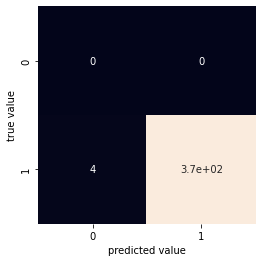

12/12 [==============================] - 0s 4ms/step - loss: 0.0053 - accuracy: 0.9973


Shaofao


accuracy score: 0.9310344827586207


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



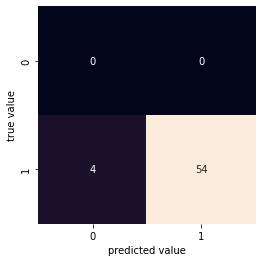

2/2 [==============================] - 0s 10ms/step - loss: 0.0830 - accuracy: 0.9828
accuracy score: 0.8275862068965517


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



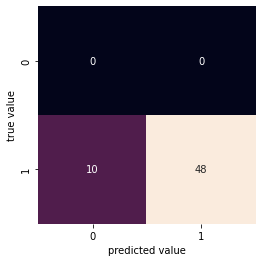

2/2 [==============================] - 0s 5ms/step - loss: 0.1854 - accuracy: 0.9655
accuracy score: 0.7758620689655172


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



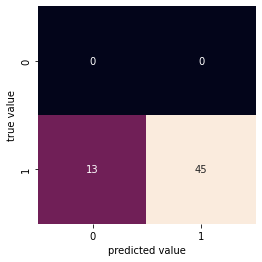

2/2 [==============================] - 0s 8ms/step - loss: 1.1418 - accuracy: 0.8793


Sodinokibi


accuracy score: 0.7762906309751434


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



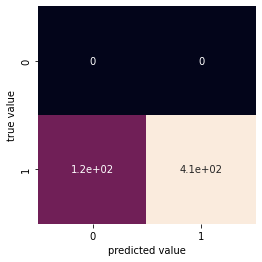

17/17 [==============================] - 0s 3ms/step - loss: 1.7678 - accuracy: 0.8432
accuracy score: 0.864244741873805


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



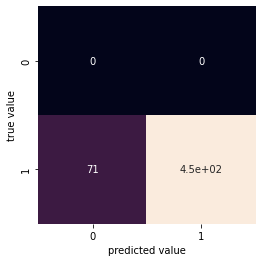

17/17 [==============================] - 0s 2ms/step - loss: 0.4851 - accuracy: 0.9006
accuracy score: 0.8546845124282982


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



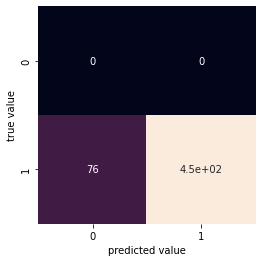

17/17 [==============================] - 0s 5ms/step - loss: 0.2211 - accuracy: 0.9713


Spora


accuracy score: 0.9387755102040817


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



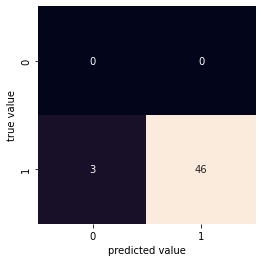

2/2 [==============================] - 0s 8ms/step - loss: 0.4273 - accuracy: 0.9592
accuracy score: 0.9591836734693877


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



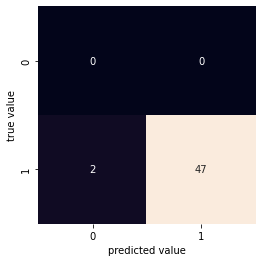

2/2 [==============================] - 0s 9ms/step - loss: 0.0948 - accuracy: 0.9796
accuracy score: 0.9591836734693877


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



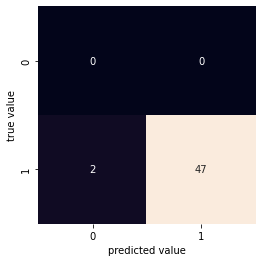

2/2 [==============================] - 0s 10ms/step - loss: 0.0085 - accuracy: 1.0000


Stop


accuracy score: 0.9925373134328358


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



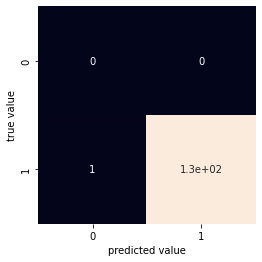

5/5 [==============================] - 0s 5ms/step - loss: 1.3980e-04 - accuracy: 1.0000
accuracy score: 0.9552238805970149


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



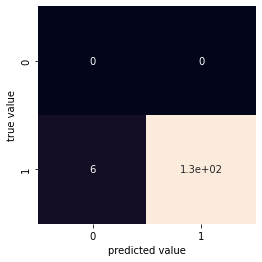

5/5 [==============================] - 0s 4ms/step - loss: 0.0170 - accuracy: 0.9925
accuracy score: 0.9850746268656716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



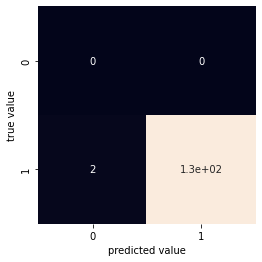

5/5 [==============================] - 0s 6ms/step - loss: 0.0094 - accuracy: 0.9925


TeslaCrypt


accuracy score: 0.9887640449438202


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



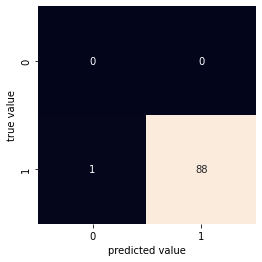

3/3 [==============================] - 0s 6ms/step - loss: 9.3077e-04 - accuracy: 1.0000
accuracy score: 0.9101123595505618


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



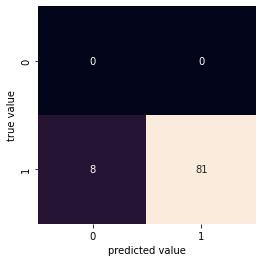

3/3 [==============================] - 0s 7ms/step - loss: 0.0497 - accuracy: 0.9663
accuracy score: 0.9325842696629213


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



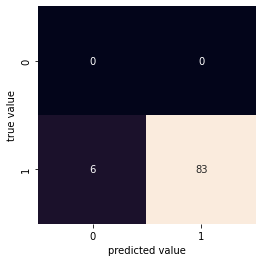

3/3 [==============================] - 0s 7ms/step - loss: 0.0535 - accuracy: 0.9775


Virlock


accuracy score: 0.9921875


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



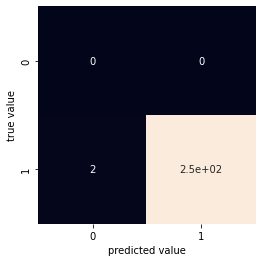

8/8 [==============================] - 0s 4ms/step - loss: 0.0064 - accuracy: 0.9961
accuracy score: 0.9765625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



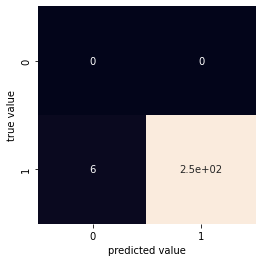

8/8 [==============================] - 0s 5ms/step - loss: 0.0080 - accuracy: 0.9961
accuracy score: 0.9921875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



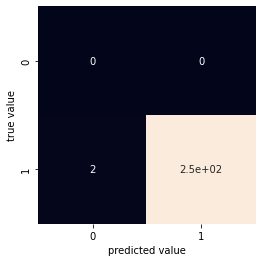

8/8 [==============================] - 0s 6ms/step - loss: 6.2321e-04 - accuracy: 1.0000


Zeus


accuracy score: 0.9886363636363636


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



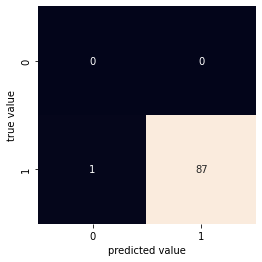

3/3 [==============================] - 0s 5ms/step - loss: 0.1072 - accuracy: 0.9886
accuracy score: 0.8863636363636364


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



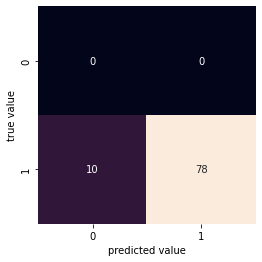

3/3 [==============================] - 0s 5ms/step - loss: 0.1238 - accuracy: 0.9886
accuracy score: 0.9431818181818182


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



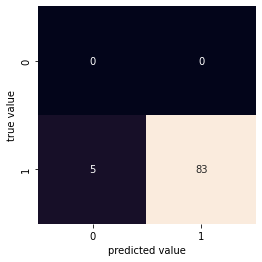

3/3 [==============================] - 0s 6ms/step - loss: 0.1059 - accuracy: 0.9886


bart


accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



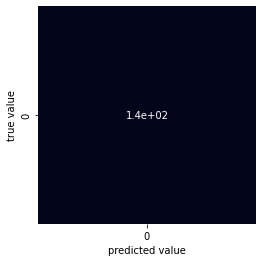

5/5 [==============================] - 0s 4ms/step - loss: 1.2480e-05 - accuracy: 1.0000
accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



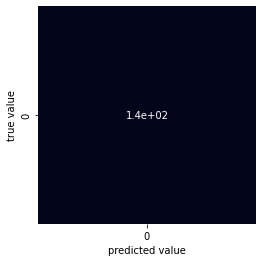

5/5 [==============================] - 0s 6ms/step - loss: 3.5715e-05 - accuracy: 1.0000
accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



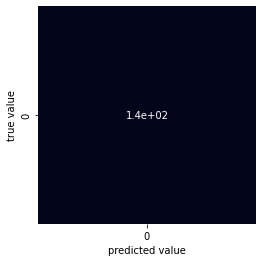

5/5 [==============================] - 0s 6ms/step - loss: 9.8727e-05 - accuracy: 1.0000


bitPaymer


accuracy score: 0.8143459915611815


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



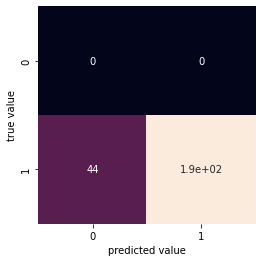

8/8 [==============================] - 0s 4ms/step - loss: 0.3454 - accuracy: 0.9325
accuracy score: 0.7088607594936709


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



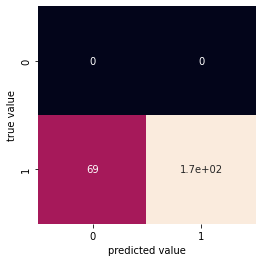

8/8 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.8565
accuracy score: 0.729957805907173


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



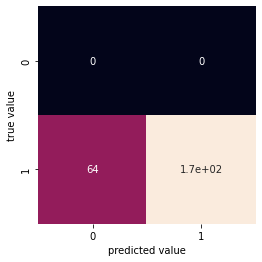

8/8 [==============================] - 0s 5ms/step - loss: 1.6801 - accuracy: 0.8228


cerber


accuracy score: 0.9970588235294118


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



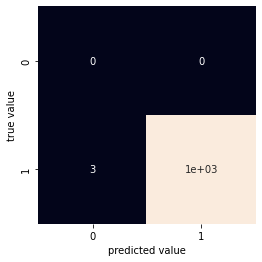

32/32 [==============================] - 0s 3ms/step - loss: 1.5262e-04 - accuracy: 1.0000
accuracy score: 0.9921568627450981


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



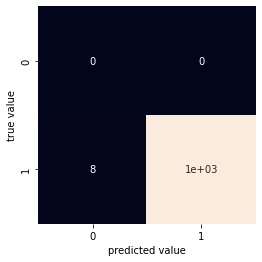

32/32 [==============================] - 0s 3ms/step - loss: 4.3350e-04 - accuracy: 1.0000
accuracy score: 0.9980392156862745


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



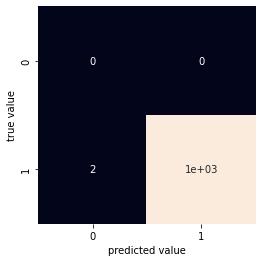

32/32 [==============================] - 0s 5ms/step - loss: 2.0925e-04 - accuracy: 1.0000


maktub


accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



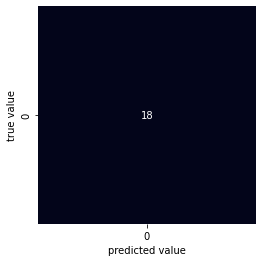

1/1 [==============================] - 0s 20ms/step - loss: 3.0197e-04 - accuracy: 1.0000
accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



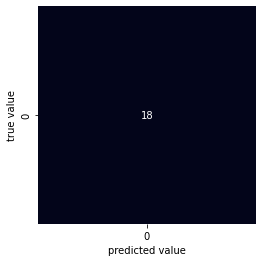

1/1 [==============================] - 0s 33ms/step - loss: 1.1418e-04 - accuracy: 1.0000
accuracy score: 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



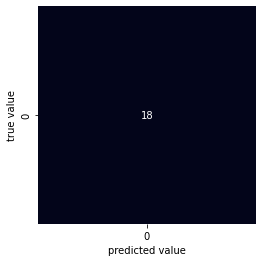

1/1 [==============================] - 0s 23ms/step - loss: 4.8294e-04 - accuracy: 1.0000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations





netwalker


accuracy score: 0.6111111111111112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



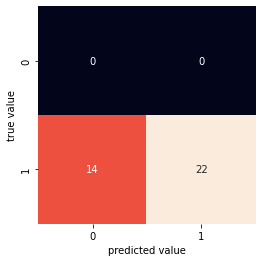

2/2 [==============================] - 0s 4ms/step - loss: 2.6184 - accuracy: 0.7500
accuracy score: 0.7222222222222222


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



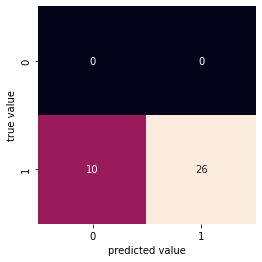

2/2 [==============================] - 0s 5ms/step - loss: 0.1630 - accuracy: 0.9444
accuracy score: 0.6388888888888888


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



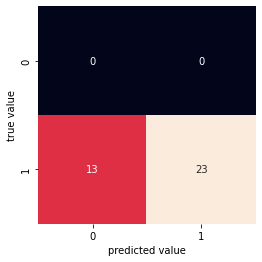

2/2 [==============================] - 0s 7ms/step - loss: 0.2981 - accuracy: 0.8889


revenge


accuracy score: 0.9634146341463414


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



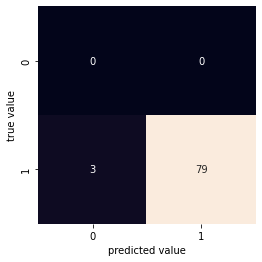

3/3 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 1.0000
accuracy score: 0.975609756097561


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



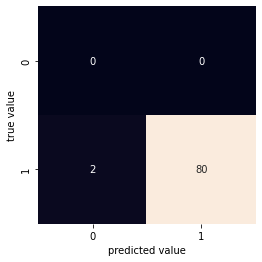

3/3 [==============================] - 0s 7ms/step - loss: 0.0579 - accuracy: 0.9878
accuracy score: 0.8170731707317073


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



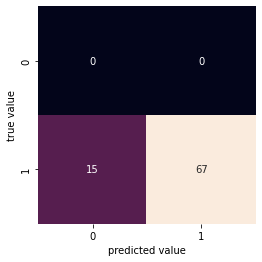

3/3 [==============================] - 0s 6ms/step - loss: 0.2141 - accuracy: 0.9268


wannaCry


accuracy score: 0.9890829694323144


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



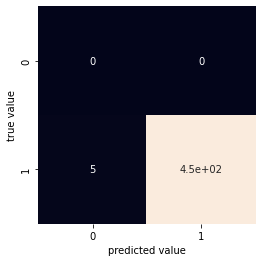

15/15 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9978
accuracy score: 0.9912663755458515


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



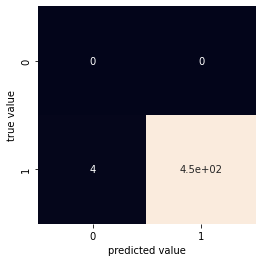

15/15 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9956
accuracy score: 0.9978165938864629


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



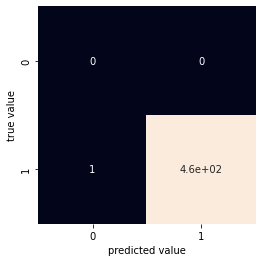

15/15 [==============================] - 0s 4ms/step - loss: 0.0251 - accuracy: 0.9978


In [229]:
filenames = glob.glob(local_path + "/*.txt")
for i, name in enumerate(category):
  print("\n")
  print(name)
  print("\n")
  indices = [i for i, x in enumerate(sample) if x == name]
  for j, pos in enumerate(indices):
    if j == 0:
      x = np.loadtxt(filenames[pos], delimiter=',', dtype = 'float32')
    else: 
      ds = np.loadtxt(filenames[pos], delimiter=',', dtype = 'float32')
      x = np.concatenate((x, ds), axis=0)
  
  label = np.delete(x, index + [31], axis=1)
  feature = np.delete(x, [30,31], axis=1)
  count = np.count_nonzero(feature == 0, axis=1)
  low_activity = np.where( count >= (feature.shape[1]/3) )
  label = np.delete(label, low_activity, axis=0)
  feature = np.delete(feature, low_activity, axis=0)
  feature_scaled, feature_scaled_10X3 = scale(feature)

  NN = metrics(model_NN, x=feature_scaled, y=label)
  CNN = metrics(model_CNN, x=feature_scaled_10X3, y=label)
  LSTM = metrics(model_LSTM, x=feature_scaled_10X3, y=label)

  if i == 0:
    NN_data = [[name, NN[1], NN[2], NN[3], NN[4]]]
    CNN_data = [[name, CNN[1], CNN[2], CNN[3], CNN[4]]]
    LSTM_data = [[name, LSTM[1], LSTM[2], LSTM[3], LSTM[4]]]
  else:
    NN_data = NN_data + [[name, NN[1], NN[2], NN[3], NN[4]]]
    CNN_data = CNN_data + [[name, CNN[1], CNN[2], CNN[3], CNN[4]]]
    LSTM_data = LSTM_data + [[name, LSTM[1], LSTM[2], LSTM[3], LSTM[4]]]
  

In [230]:
NN_df = pd.DataFrame(NN_data, columns = ['Name','Accuracy','Precision', 'Recall', 'F_measure'])

px.bar(NN_df, x='Name', y=['Accuracy'], barmode='group', title='NN')

In [231]:
CNN_df = pd.DataFrame(CNN_data, columns = ['Name','Accuracy','Precision', 'Recall', 'F_measure'])

px.bar(CNN_df, x='Name', y=['Accuracy'], barmode='group', title='CNN')

In [232]:
LSTM_df = pd.DataFrame(LSTM_data, columns = ['Name','Accuracy','Precision', 'Recall', 'F_measure'])

px.bar(LSTM_df, x='Name', y=['Accuracy'], barmode='group', title='LSTM')